# If we're talking about money, should we talk about REAL money?

### In this workbook we explore the validity of our previous suggestions by reassessing the methods used through the lens of inflation adjustment. More background on this approach is available in a blog post...

We'll begin this process in a similar manner to the previous questions with slight variations in the foundation of variables.

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import cpi
cpi.update()
sns.set(style="ticks")

In [101]:
#import data and clean column names:
big_chungus = pd.read_csv('../.csv/.etl_csvs/chungus_with_tmdb.csv')
big_chungus.columns = ['Unnamed: 0', 'tconst', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes',
       'averagerating', 'numvotes', 'Crime', 'War', 'Adventure', 'Biography',
       'n/a', 'News', 'Sci-Fi', 'Animation', 'Fantasy', 'Short', 'Talk-Show',
       'Thriller', 'Family', 'History', 'Horror', 'Drama', 'Reality-TV',
       'Romance', 'Music', 'Action', 'Musical', 'Western', 'Game-Show',
       'Mystery', 'Sport', 'Comedy', 'Documentary', 'Adult', 'director_1',
       'director_2', 'director_3', 'writer_1', 'writer_2', 'writer_3',
       'production_budget', 'domestic_gross', 'worldwide_gross',
       'release_date', 'genre_ids', 'id', 'original_language',
       'original_title_tmdb', 'popularity', 'release_date_tmdb', 'title',
       'vote_average', 'vote_count']
big_chungus.columns

Index(['Unnamed: 0', 'tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'averagerating', 'numvotes', 'Crime', 'War',
       'Adventure', 'Biography', 'n/a', 'News', 'Sci-Fi', 'Animation',
       'Fantasy', 'Short', 'Talk-Show', 'Thriller', 'Family', 'History',
       'Horror', 'Drama', 'Reality-TV', 'Romance', 'Music', 'Action',
       'Musical', 'Western', 'Game-Show', 'Mystery', 'Sport', 'Comedy',
       'Documentary', 'Adult', 'director_1', 'director_2', 'director_3',
       'writer_1', 'writer_2', 'writer_3', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'release_date', 'genre_ids', 'id',
       'original_language', 'original_title_tmdb', 'popularity',
       'release_date_tmdb', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [102]:
#Extract useful columns
money_chungus = big_chungus[
    ['tconst','primary_title', 'release_date',
    'domestic_gross', 'worldwide_gross','production_budget']]
money_chungus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146439 entries, 0 to 146438
Data columns (total 6 columns):
tconst               146439 non-null object
primary_title        146439 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
dtypes: float64(3), object(3)
memory usage: 6.7+ MB


In [103]:
#Again, we drop everything that we don't have budget/gross data for:
money_chungus.dropna(subset=['domestic_gross'], inplace=True)
money_chungus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3950 entries, 20 to 146373
Data columns (total 6 columns):
tconst               3950 non-null object
primary_title        3950 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
dtypes: float64(3), object(3)
memory usage: 216.0+ KB


/Users/elliotevins/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
#remove values with a budget or worldwide gross of zero
money_chungus = money_chungus[money_chungus.production_budget != 0]
money_chungus = money_chungus[money_chungus.worldwide_gross != 0]

In [105]:
#Let's extract the year from each release date to use in our adjustment formula:
money_chungus['year'] = pd.DatetimeIndex(money_chungus['release_date']).year

In [106]:
#Since the cpi calculator we're using uses the 2018 cpi as a benchmark, we'll revert all years after 2018 to that value of 100:
money_chungus['year'] = money_chungus['year'].replace(2019, 2018)
(money_chungus['year'] == 2019).sum()

0

In [107]:
#Now let's use the cpi module to create variables in real dollars
money_chungus['real_gross'] = money_chungus.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
money_chungus['real_gross'].astype(int)
money_chungus['real_budget'] = money_chungus.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
money_chungus['real_budget'].astype(int)
money_chungus.head()

,tconst,primary_title,release_date,domestic_gross,worldwide_gross,production_budget,year,real_gross,real_budget
20,tt0249516,Foodfight!,2012-12-31,0.0,73706.0,45000000.0,2012,8.061227e+04,4.921651e+07
33,tt0293429,Mortal Kombat,1995-08-18,70433227.0,122133227.0,20000000.0,1995,2.012369e+08,3.295367e+07
40,tt0326592,The Overnight,2015-06-19,1109808.0,1165996.0,200000.0,2015,1.235311e+06,2.118894e+05
48,tt0337692,On the Road,2013-03-22,720828.0,9313302.0,25000000.0,2013,1.003891e+07,2.694778e+07
54,tt0359950,The Secret Life of Walter Mitty,2013-12-25,58236838.0,187861183.0,91000000.0,2013,2.024977e+08,9.808994e+07


In [111]:
# Here we'll create an roi variable AFTER adjusting for inflation:
money_chungus['real_roi'] = (money_chungus['real_gross']-money_chungus['real_budget'])/money_chungus['real_budget']

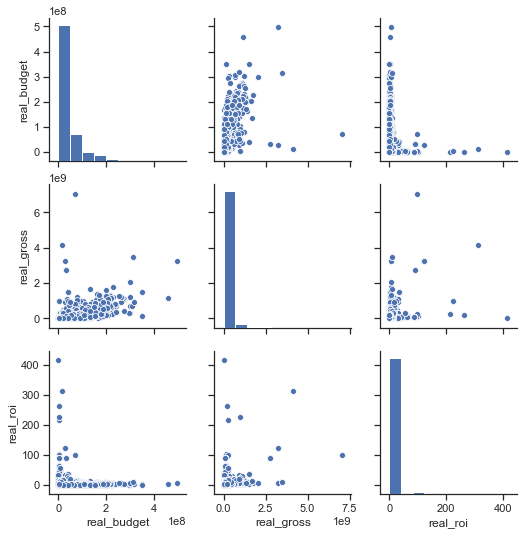

In [112]:
#We can assume that the distribution of figures is similar so let's look and see a scatter matrix on these points: 
money_table = money_chungus[['real_budget','real_gross', 'real_roi']]
sns.pairplot(money_table);

In [113]:
money_table.corr()

,real_budget,real_gross,real_roi
real_budget,1.000000,0.522558,-0.103467
real_gross,0.522558,1.000000,0.313358
real_roi,-0.103467,0.313358,1.000000


## Looks like budget and revenue have a much smaller, but still statistically significant, correlation when considering figures that are adjusted for inflation.

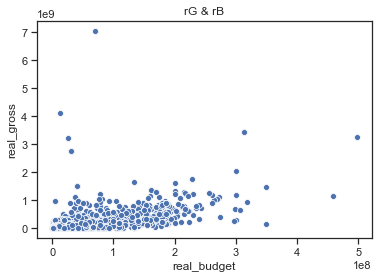

In [76]:
#The gross values really seem to flatten significantly with a perspective of inflation:
sns.scatterplot(money_chungus['real_budget'], money_chungus['real_gross']).set_title('rG & rB');

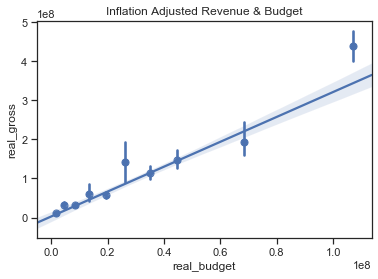

In [78]:
#Budget outliers still exist but the threshold has fallen:
sns.regplot(money_chungus['real_budget'], money_chungus['real_gross'], x_bins=10).set_title('Inflation Adjusted Revenue & Budget');


In [114]:
#To adapt to this change, the new definition for top budget can be 100 million
top_budgets = money_chungus.loc[money_chungus['real_budget'] > 100_000_000]
len(top_budgets)

358

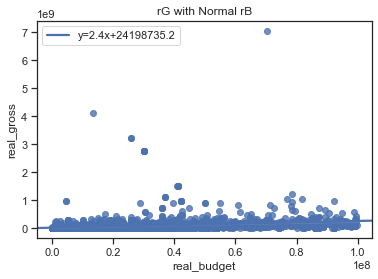

0.23916344677288048


In [115]:
normal_budgets = money_chungus.loc[money_chungus['real_budget'] < 100_000_000]
slope, intercept, r_value, p_value, std_err = stats.linregress(normal_budgets['real_budget'],normal_budgets['real_gross'])
ax = sns.regplot(x="real_budget", y="real_gross", data=normal_budgets, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title('rG with Normal rB')
ax.legend()
plt.show()
print(r_value)

## Inflation adjusted figures show a much less significant connection between budget and revenue under $100 million.

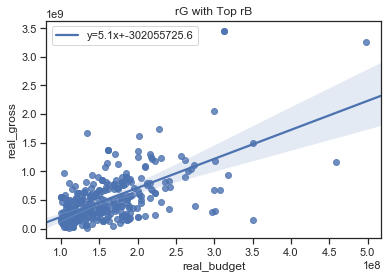

0.6184599946951524


In [116]:
#Does this hold true for big budget movies? 
slope, intercept, r_value, p_value, std_err = stats.linregress(top_budgets['real_budget'],top_budgets['real_gross'])
axtop = sns.regplot(x="real_budget", y="real_gross", data=top_budgets, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
axtop.legend()
axtop.set_title('rG with Top rB')
plt.show()
print(r_value)

## Not too surprisingly, the top movie budgets actually show a higher correlation and return when figures are adjusted for inflation.

# This is where we previously looked at ROI but a cursory analysis shows that there is little  change in the projections from the regression analysis previously established so let's check out our work with genre: